In [ ]:
try:
    import tinygp
except ImportError:
    %pip install -q tinygp

try:
    import george
except ImportError:
    %pip install -q george

try:
    import celerite2
except ImportError:
    %pip install -q celerite2

from jax.config import config

config.update("jax_enable_x64", True)

(george)=

# Comparison With george

One of the `tinygp` design decisions was to provide a high-level API similar to the one provided by the [george](https://george.readthedocs.io) GP library.
This was partly because I (as the lead developer of `george`) wanted to ease users' transitions away from `george` to something more modern (like `tinygp`).
I also quite like the `george` API and don't think that there exist other similar tools.
The defining feature is `tinygp` does not include built-in implementations of inference algorithms.
Instead, it provides an expressive model-building interface that makes it easy to experiement with different kernels while still integrating with your favorite inference engine.

In this document, we compare the interfaces and computational performance of `george` and `tinygp` for constructing kernel models and evaluating the GP marginalized likelihood.
Since `tinygp` supports GPU-acceleration, we have executed this notebook on a machine with the following GPU:

In [1]:
!nvidia-smi --query-gpu=gpu_name --format=csv

name
NVIDIA A100-PCIE-40GB


By default, the CPU versions of both `george` and `tinygp` will also use parellelized linear algebra libraries to take advantage of multiple CPU threads, however to make the benchmarks more replicable, we'll disable this parallelization for the remainder of this notebook:

In [2]:
import os

os.environ["JAX_ENABLE_X64"] = "True"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["XLA_FLAGS"] = (
    os.environ.get("XLA_FLAGS", "")
    + " --xla_cpu_multi_thread_eigen=false intra_op_parallelism_threads=1"
)

Then we generate some simulated data and define functions for computing the GP log likelihood using `george` and `tinygp` (with separate CPU and GPU version).
As mentioned above, the syntax of these functions is quite similar, but there are a few differences.
Most notably, the units of the "metric" or "length scale" parameter in the kernel is different (length-squared in `george` and not squared in `tinygp`).
Also, the `gp.compute` method no longer exists in `tinygp` since this would be less compatible with `jax`'s preference for pure functional programming.

In [6]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import celerite2
import george
import tinygp

sigma = 1.5
rho = 2.5
jitter = 0.1

random = np.random.default_rng(49382)
x = np.sort(random.uniform(0, 10, 100_000))
y = np.sin(x) + jitter * random.normal(0, 1, len(x))


def george_loglike(x, y, **kwargs):
    kernel = sigma**2 * george.kernels.Matern32Kernel(rho**2)
    gp = george.GP(kernel, **kwargs)
    gp.compute(x, jitter)
    return gp.log_likelihood(y)


def celerite_loglike(x, y):
    kernel = celerite2.terms.Matern32Term(sigma=sigma, rho=rho)
    gp = celerite2.GaussianProcess(kernel, x, diag=jitter**2)
    return gp.log_likelihood(y)


def tinygp_loglike(x, y):
    kernel = sigma**2 * tinygp.kernels.Matern32(rho)
    gp = tinygp.GaussianProcess(kernel, x, diag=jitter**2)
    return gp.log_probability(y)


@partial(jax.jit, backend="cpu")
def quasisep_loglike(x, y):
    kernel = tinygp.solvers.quasisep.kernels.Matern32(sigma=sigma, scale=rho)
    gp = tinygp.GaussianProcess(kernel, x, diag=jitter**2)
    return gp.log_probability(y)


hodlr_loglike = partial(
    george_loglike, solver=george.solvers.HODLRSolver, tol=0.5
)
tinygp_loglike_cpu = jax.jit(tinygp_loglike, backend="cpu")
tinygp_loglike_gpu = jax.jit(tinygp_loglike, backend="gpu")

Now we benchmark the computational cost of computing the log likelihood using each of these methods:

In [7]:
ns = [10, 20, 100, 200, 1_000, 2_000, 10_000, 20_000, len(x)]
george_time = []
hodlr_time = []
cpu_time = []
gpu_time = []
quasisep_time = []
celerite_time = []
for n in ns:
    print(f"\nN = {n}:")

    args = x[:n], y[:n]
    gpu_args = jax.device_put(x[:n]), jax.device_put(y[:n])

    if n < 10_000:
        results = %timeit -o george_loglike(*args)
        george_time.append(results.average)

        tinygp_loglike_cpu(*args).block_until_ready()
        results = %timeit -o tinygp_loglike_cpu(*args).block_until_ready()
        cpu_time.append(results.average)

    if n <= 20_000:
        results = %timeit -o hodlr_loglike(*args)
        hodlr_time.append(results.average)

        tinygp_loglike_gpu(*gpu_args).block_until_ready()
        results = %timeit -o tinygp_loglike_gpu(*gpu_args).block_until_ready()
        gpu_time.append(results.average)

    results = %timeit -o quasisep_loglike(*args)
    quasisep_time.append(results.average)

    results = %timeit -o celerite_loglike(*args)
    celerite_time.append(results.average)


N = 10:
391 µs ± 5.66 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
13.8 µs ± 23.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
289 µs ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
92.4 µs ± 103 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
12.5 µs ± 6.57 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
117 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

N = 20:
398 µs ± 3.67 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
24 µs ± 106 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
301 µs ± 10.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
95.1 µs ± 426 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
13.1 µs ± 6.15 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
117 µs ± 257 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

N = 100:
794 µs ± 1.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
364 µs ± 1.85 µs per loop (mean ± std. 

In the plot of this benchmark, you'll notice several features:

1. For very small datasets, the `tinygp` CPU implementation is significantly faster than any of the other implementations. This is because `jax.jit` removes a lot of the Python overhead that is encountered when chaining `numpy` functions.
2. For medium to large datasets, `tinygp` is generally faster than `george`, with the GPU version seeing a significant advantage.
3. The CPU implementations approach the expected asymptotic complexity of $\mathcal{O}(N^3)$ only for the largest values of $N$. This is probably caused by memory allocation overhead or other operations with better scaling than the Cholesky factorization.
4. The approximate "HODLR" solver from `george` outperforms the GPU-enabled `tinygp` exact solver, but only for very large datasets, and it's important to note that the HODLR method does not scale well to larger input dimensions. Any existing or future approximate solvers like this that are implemented in `jax` could be easily used in conjunction with `tinygp`, but such things have not yet been implemented.

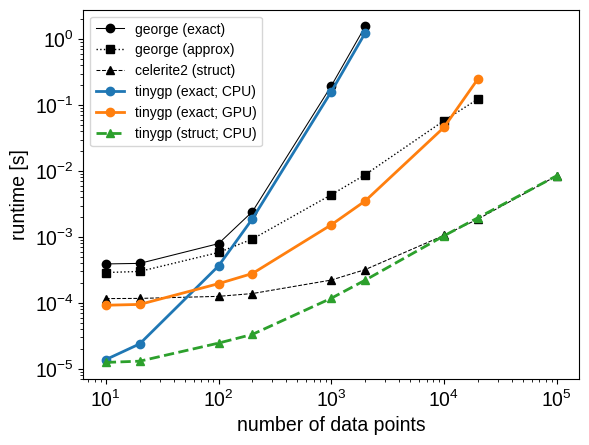

In [8]:
plt.loglog(
    ns[: len(george_time)],
    george_time,
    "o-",
    color="k",
    lw=0.75,
    label="george (exact)",
)
plt.loglog(
    ns[: len(hodlr_time)],
    hodlr_time,
    "s:",
    color="k",
    lw=1,
    label="george (approx)",
)
plt.loglog(
    ns, celerite_time, "^--", color="k", lw=0.75, label="celerite2 (struct)"
)

plt.loglog(
    ns[: len(cpu_time)],
    cpu_time,
    "o-",
    color="C0",
    lw=2,
    label="tinygp (exact; CPU)",
)
plt.loglog(
    ns[: len(gpu_time)],
    gpu_time,
    "o-",
    color="C1",
    lw=2,
    label="tinygp (exact; GPU)",
)
plt.loglog(
    ns, quasisep_time, "^--", color="C2", lw=2, label="tinygp (struct; CPU)"
)

plt.legend(fontsize=10)
plt.xlabel("number of data points")
plt.ylabel("runtime [s]");